## **Sprint 3: H&M Personalized Fashion Recommendations**

### Matrix Factorization

___

Atoosa Rashid

[GitHub](https://github.com/atoosa-r/)

[LinkedIn](https://www.linkedin.com/in/atoosarashid/) 
____

### **Introduction**

In this data analysis, we explore H&M Group datasets, including transactions, customer information, and article details. H&M Group operates globally with 53 online markets and approximately 4850 stores. The objective is to uncover insights for developing effective product recommendations.

In this notebook we will be performing Matrix Factorization and providing further recommendations. 

In [2]:
#Importing libraries: 

import numpy as np                 
import pandas as pd    
              
import matplotlib.pyplot as plt      
import matplotlib.image as mpimg      
import seaborn as sns         

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine as cosine_distance

from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise.model_selection import train_test_split

In [3]:
#Importing Dataframes:

articles_df=pd.read_csv("/Users/Atoosa/Desktop/cleaned_articles_df.csv") 

m_matrix=pd.read_csv("/Users/Atoosa/Desktop/melted_dataframe.csv")

In [4]:
#Sanity check:

m_matrix.head(3)

,customer_id,article_id,score
0,0dbe2f2ceb2e205216589497f46228ab5b6eb8927032f4...,111565001,5.0
1,18cbcb477a05ec64929809693fcac49edd404571f7e667...,111565001,2.5
2,190ce2b4681d15e1b4e752aaefdf07d73cf3265d33e5de...,111565001,5.0


In [5]:
#Sanity check:

articles_df.head(3)

,article_id,prod_name,product_type_name,product_group_name,colour_group_name,department_name,index_group_name,section_name,garment_group_name,detail_desc,preprocessed_detail_desc
0,108775015,Strap top,Vest top,Garment Upper body,Black,Jersey Basic,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,jersey top narrow shoulder straps
1,108775044,Strap top,Vest top,Garment Upper body,White,Jersey Basic,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,jersey top narrow shoulder straps
2,108775051,Strap top (1),Vest top,Garment Upper body,Off White,Jersey Basic,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,jersey top narrow shoulder straps


In [6]:
#Checking for nans:

m_matrix.isna().sum()

customer_id    0
article_id     0
score          0
dtype: int64

In [7]:
m_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470191 entries, 0 to 470190
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  470191 non-null  object 
 1   article_id   470191 non-null  int64  
 2   score        470191 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.8+ MB


In [8]:
#Sorting our values based on the order below: 

mm_df = m_matrix.sort_values(by=['customer_id', 'article_id','score'])

In [9]:
#Sanity check on new sorted order:

mm_df.head(10)

,customer_id,article_id,score
14559,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,794321007,5.0
1041,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,448509014,5.0
8336,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,719530003,5.0
9140,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,734592001,5.0
39368,0002cca4cc68601e894ab62839428e5f0696417fe0f9e8...,910601002,5.0
4371,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,624486001,5.0
4290,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,621381012,2.5
4660,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,640021012,2.5
18792,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,827487003,2.5
28968,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,880017001,5.0


In [11]:
mm_df.value_counts('score', ascending=False)

score
5.000000    356805
2.500000     89914
1.666667     13941
3.333333      4220
1.250000      3081
1.000000       686
0.833333       424
3.750000       292
2.000000       276
0.714286        89
3.000000        86
0.625000        68
4.000000        50
0.555556        47
1.428571        45
1.111111        23
0.357143        17
1.875000        12
4.166667        10
0.294118         9
0.500000         8
3.125000         8
2.142857         7
0.333333         7
0.416667         7
1.071429         6
4.285714         5
0.384615         5
0.666667         4
2.222222         4
3.571429         3
0.250000         3
0.588235         3
0.200000         3
1.500000         2
4.375000         2
0.526316         2
0.454545         2
0.263158         2
2.857143         2
1.923077         2
0.217391         1
1.363636         1
2.272727         1
3.809524         1
3.888889         1
1.200000         1
0.400000         1
4.500000         1
2.083333         1
Name: count, dtype: int64

___
**Using the Surprise Library for Matrix Factorization**

**Step 1:** Load the Dataset from a DataFrame

We load our sorted Dataframe into a Surprise dataset. This dataset will be used to build and evaluate our recommendation models. The `Reader` class is used to specify the rating scale, which ranges from 0 to 5 in our case.

**Step 2:** Build the Full Training Set

We convert the loaded dataset into a full training set. This training set includes all the data from our original DataFrame and is structured in a way that Surprise's algorithms can use for training.

In [12]:
#Step 1:

my_dataset = Dataset.load_from_df(mm_df, Reader(rating_scale=(0, 5)))

#Step 2:

my_train_dataset = my_dataset.build_full_trainset()

In [13]:
#Sanity check :

my_train_dataset

The dataset has been successfully converted into a trainset object, which is now ready to be used for training our recommendation model in the Surprise library. We'll continue by first performing some hyperparameter tuning to find the best parameters for our algorithm.  

In [14]:
#Parameter grid for cross-validation:
param_grid = {
    'n_factors': [10, 20, 50],
    'n_epochs': [100, 200, 500],
    'lr_all': [0.005, 0.01, 0.1],
    'biased': [False]
}

#Initializing the GridSearchCV:
grid_search = GridSearchCV(FunkSVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

grid_search.fit(my_dataset)


In [15]:
#Getting the best parameters from the grid search:
best_params = grid_search.best_params['rmse']

# Print the best parameters
print(f"The best parameters for the FunkSVD algorithm: {best_params}")

The best parameters for the FunkSVD algorithm: {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.1, 'biased': False}


Now we can initialize the FunkSVD algorithm with our best parameters. 

In [16]:
#Initializing the FunkSVD algorithm with best parameters:
my_algorithm = FunkSVD(n_factors=10,
                       n_epochs=100,
                       lr_all=0.1,   
                       biased=False,  #Forcing the algorithm to store all latent information in the matrices
                       verbose=1)

#Fitting the algorithm to the training data:
my_algorithm.fit(my_train_dataset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [17]:
#The user matrix is under the SVD.pu attribute:

C = my_algorithm.pu
C.shape

(135897, 10)

In [18]:
#The articles matrix is under the SVD.qi attribute:

A = my_algorithm.qi.T
A.shape

(10, 23083)

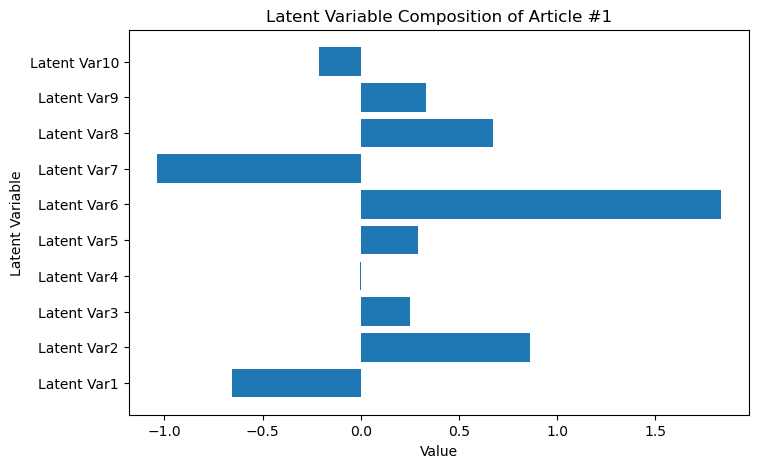

In [25]:
#Visualizing the composition of latent variables for the first article in a dataset:

first_article = A[:, 0]

plt.figure(figsize=(8, 5))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_article)+1)], first_article)
plt.title("Latent Variable Composition of Article #1")
plt.ylabel("Latent Variable")
plt.xlabel("Value")

plt.show()

In [20]:
inner_article_id = my_train_dataset.to_inner_iid(448509014) # find the inner representation of item 1
article_profile = A[:, inner_article_id]
article_profile

array([-0.29042579,  0.45583962, -0.29808021, -0.21477959,  1.2419068 ,
        0.28111903, -1.46148955, -1.0169479 ,  0.69082631, -1.09942475])

In [22]:
inner_user_id = my_train_dataset.to_inner_uid('ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264') # find the inner representation of user 1
user_profile = C[inner_user_id]
user_profile

array([ 0.54640442,  0.91880579, -0.11207646,  0.05671644,  1.19310279,
        1.43888333, -0.50501613, -0.00339903,  1.03415939, -0.47621025])

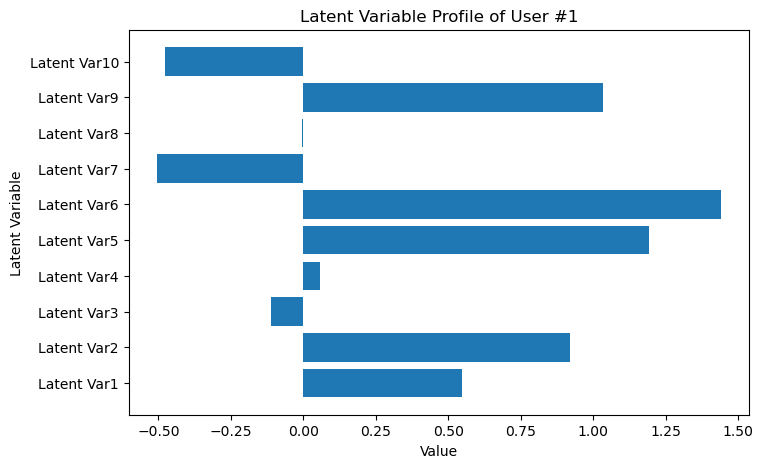

In [26]:
plt.figure(figsize=(8, 5))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_article)+1)], user_profile)
plt.title("Latent Variable Profile of User #1")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

In [27]:
expected_rating = np.dot(user_profile, article_profile)
expected_rating

4.147098603945535

In [28]:
my_train_dataset, my_test_dataset = train_test_split(my_dataset, test_size=0.5)

predictions = my_algorithm.test(my_test_dataset)

___
#### **Evaluating the Recommendation System: MSE, RMSE, and MAE**

In our recommendation system, RMSE, MSE, MAE, and FCP  are crucial metrics for evaluating the accuracy of predicted ratings:

- **RMSE (Root Mean Squared Error)** offers an interpretable measure of prediction accuracy in the same scale as the ratings. 
    - A lower RMSE means that the predictions are closer to the actual ratings.
- **MSE (Mean Squared Error)** helps identify large errors by giving them more weight. 
    - A lower MSE indicates better accuracy.
- **MAE (Mean Absolute Error)** provides a robust average error metric that is less influenced by outliers. 
    - A lower MAE indicates better performance.
- **FCP (Fraction of Concordant Pairs)** measures how well the system preserves the relative ordering of item ratings. 
    - A higher FCP value indicates that the system is better at maintaining the correct order of preferences.

Using these metrics, we can assess and improve the performance of our recommendation system, ensuring it provides accurate and reliable recommendations.

In [29]:
#RMSE (Root Mean Squared Error):

RMSE = accuracy.rmse(predictions, verbose=False)
print(RMSE)

0.16951039582613642


In [30]:
#MSE (Mean Squared Error):

MSE = accuracy.mse(predictions, verbose=False)
print(MSE)

0.028733774293133448


In [31]:
#MAE (Mean Absolute Error):

MAE = accuracy.mae(predictions, verbose=False)
print(MAE)

0.09038932324006814


In [32]:
# FCP - Fraction of Concordant Pairs, the fraction of pairs whose relative ranking order is correct

FCP = accuracy.fcp(predictions, verbose=False)
print(FCP)

0.6449189566858999
